In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow.keras.metrics


In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import os
import re

In [ ]:
!git clone https://github.com/Jmazo25/Monografia.git

Cloning into 'Monografia'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.


In [ ]:
df_train = pd.read_csv("/content/Monografia/train.csv")
df_test = pd.read_csv("/content/Monografia/test.csv")

In [ ]:
df_train.head(3)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative


In [ ]:
df_test.head(3)

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative


In [ ]:
df_train.dropna(axis = 0, how ='any',inplace=True)
df_train.reset_index(inplace=True)
df_train.shape

(27480, 5)

#Preprocesamiento

##Limpieza y eliminación de StopWords

In [ ]:
def clean_text(t):
  tl = []
  t = t.lower().split()
  for i in t:
    if i not in stopwords.words('english'):
      tl.append(i)
  return " ".join(tl)

In [ ]:
df_train['text'] = df_train['text'].apply((lambda x:re.sub('@[^\s]+','',x)))
df_train['text'] = df_train['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
text1 = df_train['text'].apply(lambda x: clean_text(x))

Se convierte la serie "text1" en una lista de valores

In [ ]:
text = list(text1.values)

Antes de iniciar con la tokenización se crea una serie que contiene la longitud de cada tweet medida en palabras y se grafica con su respectiva descripción para conocer el comportamiento de las longitudes 

In [ ]:
dim_tw = text1.str.split().str.len()

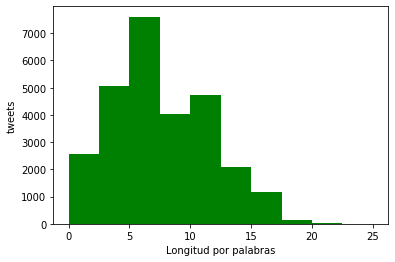

In [ ]:
fig, ax1 = plt.subplots()
plt.hist(dim_tw,color='green')
ax1.set_xlabel('Longitud por palabras'), ax1.set_ylabel("tweets")
plt.show()

In [ ]:
dim_tw.describe()

count    27480.000000
mean         7.416230
std          3.983212
min          0.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         25.000000
Name: text, dtype: float64

#Tokenización

In [ ]:
tokenizer = Tokenizer(num_words=12000)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)

Se crea un objeto tokenizer para un diccionario de 12000 palabras, luego se entrena el objeto con los tweets que debemos clasificar creando un vocabulario interno para posteriormente asignarles un valor entero a cada palabra, es decir un índice.

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 28612 unique tokens.


In [ ]:
data = pad_sequences(sequences, maxlen=max(dim_tw))

In [ ]:
data.shape

(27480, 25)

el ndarray Data contiene 27480 vectores de longitud de 25 elementos, configurados de esta forma según el análisis anterior sobre la longitud máxima de un Tweet, el cual provee que la máxima longitud es de 25 palabras

In [ ]:
labels1 = {"sentiment": {"neutral":0,"positive":1,"negative":2}}

In [ ]:
df_train = df_train.replace(labels1)
labels = df_train['sentiment']
#labels
labels = to_categorical(labels)

In [ ]:
print('Shape of data tensor:', data.shape)
print('Shape of label label:', labels.shape)

Shape of data tensor: (27480, 25)
Shape of label label: (27480, 3)


#Split de la data

Se divide el dataset en los conjuntos de entrenamiento, validación y test

In [ ]:
X_train,x_test,Y_train,y_test = train_test_split(data,labels, test_size=0.15, random_state=42)
x_train,x_val,y_train,y_val = train_test_split(X_train,Y_train, test_size=0.1, random_state=42)
x_train.shape, y_train.shape,x_val.shape, y_val.shape, x_test.shape, y_test.shape

((21022, 25), (21022, 3), (2336, 25), (2336, 3), (4122, 25), (4122, 3))

#Importar el archivo Glove de dimensión 100

Debido a que pesa más de 400 Mb se pondrá el enlace donde se puede descargar para uso del lector, se debe establecer la variable Path con la ruta donde el archivo esté puesto.
https://nlp.stanford.edu/projects/glove/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/'

Se escoge un word embedding de dimensión 100 para luego generar un diccionario, esto solo para guardar en memoria las palabras con sus respectivos coeficientes

In [ ]:
embeddings_index = {}
f = open(os.path.join(path, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Se genera la matriz de embedimiento tomando el orden de las palabras según nuestro word_index, luego se parametriza con número de filas igual al tamaño del word_index + 1 fila (utilizada para el Padding) y con 100 columnas como la dimensión del word embedding que corresponde a los coeficientes de cada palabra

In [ ]:
embedding_matrix = np.zeros((tokenizer.num_words + 1, 100))
for i in range(1,tokenizer.num_words):
  word = tokenizer.index_word[i]
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
      embedding_matrix[i] = embedding_vector
  else:
      embedding_matrix[i] = embeddings_index.get('unk')

In [ ]:
embedding_matrix.shape

(12001, 100)

Se configura la capa de embedding tomando el parámetro "Input_dim" como el número de filas en la matriz, "output"_dim como la dimensión del embedding utilizado o las columnas de la matriz y input_length como el tamaño de la entrada de la variable "data" que en este caso es 30

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(tokenizer.num_words + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=25,
                            trainable=False,
                            mask_zero=True)

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import Model,Input

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional
from keras.layers import Flatten
from keras.layers import Embedding

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Se definen las métricas para ambos modelos

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

##Modelo RNN

In [ ]:
model1 = Sequential()
e = embedding_layer
model1.add(e)
model1.add(Bidirectional(LSTM(50)))
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(3, activation='softmax'))
# Compilar el modelo
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',recall_m,f1_m,tensorflow.keras.metrics.Precision()])
# resumen del modelo
print(model1.summary())
# Entrenamiento del modelo
model1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, verbose=2)
# evaluación del modelo
loss, accuracy, recall, F1, Precision = model1.evaluate(x_test,y_test , verbose=0,batch_size=32)
print('Accuracy: %f' % (accuracy*100))
print('recall: %f' % (recall*100))
print('Precision: %f' % (Precision*100))
print('F1: %f' % (F1*100))

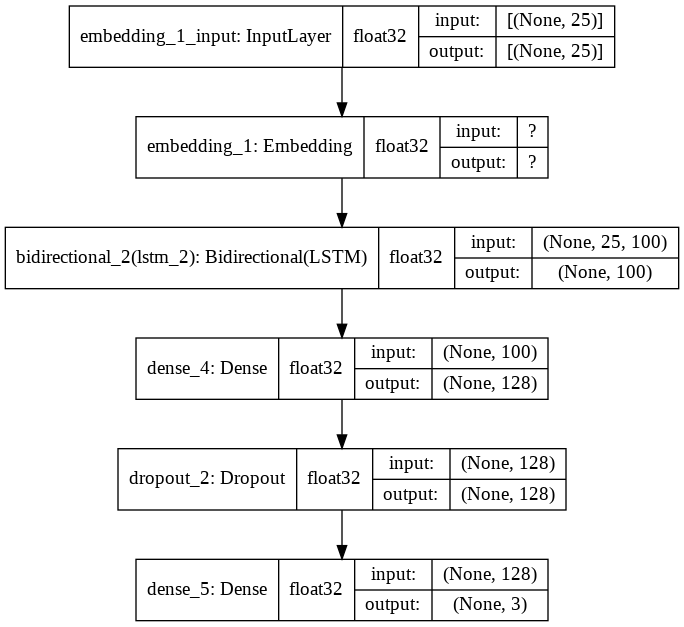

In [ ]:
tensorflow.keras.utils.plot_model(model1, "rnn_model_sentiment.png",show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96,
    layer_range=None)

##Modelo CNN


In [ ]:
from tensorflow.keras import callbacks

In [ ]:
sequence_input = Input(shape=(25,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu',padding = 'same')(embedded_sequences)
x = MaxPooling1D(2)(x)

x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(8)(x)

"""
x = Conv1D(128, 2, activation='relu')(x)
x = MaxPooling1D(2)(x)  # global max pooling
"""
x = Flatten()(x)
#x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.32)(x)
preds = Dense(3, activation='softmax')(x)
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              #metrics=['acc'])
              metrics=['accuracy',recall_m,f1_m])
model.summary()
"""
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=5, batch_size=128,callbacks=[early])
loss, accuracy,recall, F1 = model.evaluate(x_test,y_test , verbose=0,batch_size=128)
print('Accuracy: %f' % (accuracy*100))
print('recall: %f' % (F1*100))
print('F1: %f' % (F1*100))
"""

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 25, 100)           1200100   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 25, 128)           64128     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 12, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 8, 128)            82048     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0   

"\nmodel.fit(x_train, y_train, validation_data=(x_val, y_val),\n          epochs=5, batch_size=128,callbacks=[early])\nloss, accuracy,recall, F1 = model.evaluate(x_test,y_test , verbose=0,batch_size=128)\nprint('Accuracy: %f' % (accuracy*100))\nprint('recall: %f' % (F1*100))\nprint('F1: %f' % (F1*100))\n"

In [ ]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=32,callbacks=[early])
loss, accuracy,recall, F1 = model.evaluate(x_test,y_test , verbose=0,batch_size=128)
print('Accuracy: %f' % (accuracy*100))
print('recall: %f' % (recall*100))
print('F1: %f' % (F1*100))

Epoch 1/10
657/657 [==============================] - 38s 56ms/step - loss: 0.8373 - accuracy: 0.6289 - recall_m: 0.5033 - f1_m: 0.5727 - val_loss: 0.7911 - val_accuracy: 0.6640 - val_recall_m: 0.5608 - val_f1_m: 0.6292
Epoch 2/10
657/657 [==============================] - 37s 56ms/step - loss: 0.6924 - accuracy: 0.7163 - recall_m: 0.6451 - f1_m: 0.6977 - val_loss: 0.7602 - val_accuracy: 0.6836 - val_recall_m: 0.5993 - val_f1_m: 0.6570
Epoch 3/10
657/657 [==============================] - 37s 57ms/step - loss: 0.5905 - accuracy: 0.7637 - recall_m: 0.7140 - f1_m: 0.7539 - val_loss: 0.8394 - val_accuracy: 0.6772 - val_recall_m: 0.6096 - val_f1_m: 0.6563
Epoch 4/10
657/657 [==============================] - 38s 57ms/step - loss: 0.4856 - accuracy: 0.8090 - recall_m: 0.7775 - f1_m: 0.8061 - val_loss: 1.0027 - val_accuracy: 0.6717 - val_recall_m: 0.6348 - val_f1_m: 0.6644
Epoch 5/10
657/657 [==============================] - 37s 57ms/step - loss: 0.4039 - accuracy: 0.8467 - recall_m: 0.8234

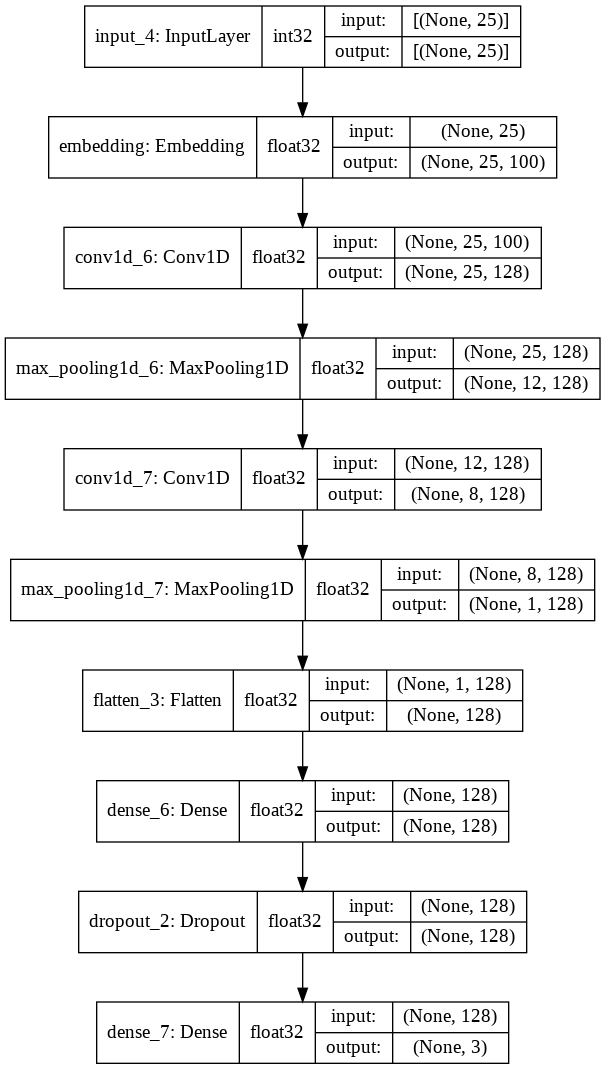

In [ ]:
tensorflow.keras.utils.plot_model(model, "cnn_model_sentiment.png",show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96,
    layer_range=None)

##Se va utilizar el método de Girdsearch con validación cruzada para la búsqueda de los mejores hiperparámetros

In [ ]:
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit, GridSearchCV

In [ ]:
skf = StratifiedShuffleSplit(n_splits=5,test_size=0.15,random_state=777)

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
def algorithm_pipeline(X_train, x_test, Y_train, y_test, 
                       model, param_grid, cv=5, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=3
    )
    fitted_model = gs.fit(X_train, Y_train)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(x_test)
    else:
      pred = fitted_model.predict(x_test)
    
    return fitted_model, pred

In [ ]:
def build_lstm(activation = 'relu',
              dropout_rate = 0.2,
              optimizer = 'Adam', neurons = 50):
    model = Sequential()
    
    e = embedding_layer
    model.add(e)
    model.add(LSTM(neurons))
    #model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))

    
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer, 
        metrics=['accuracy', recall_m, f1_m]
    )
    
    return model

In [ ]:
def build_cnn(activation = 'relu',
              dropout_rate = 0.2,
              optimizer = 'Adam', neurons = 128):
    model = Sequential()

    e_l = embedding_layer
    model.add(e_l)
    model.add(Conv1D(neurons, kernel_size=(5),
              activation=activation,padding='same'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(neurons,5, activation=activation))
    model.add(MaxPooling1D(10))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(neurons, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer, 
        metrics=['accuracy',recall_m, f1_m]
    )
    
    return model

##GridSearch Modelo 1

In [ ]:
param_grid = {
              'epochs':[3,5,7,10],
              'batch_size':[32,128],
              #'neurons' : [50,70,90],
              #'batch_size' :          [32, 128],
              #'optimizer' :           ['Adam', 'Nadam'],
              #'dropout_rate' :        [0.2, 0.3],
              #'activation' :          ['relu', 'elu']
             }

In [ ]:
model = KerasClassifier(build_fn = build_lstm, verbose=2)

model, pred = algorithm_pipeline(X_train, x_test, Y_train, y_test, model, 
                                        param_grid, cv=3, scoring_fit='neg_log_loss')

print(model.best_score_)
print(model.best_params_)
print(model.cv_results_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 101.5min finished


Epoch 1/7
730/730 - 90s - loss: 0.8540 - accuracy: 0.6180 - recall_m: 0.4567 - f1_m: 0.5309
Epoch 2/7
730/730 - 87s - loss: 0.7410 - accuracy: 0.6915 - recall_m: 0.6133 - f1_m: 0.6676
Epoch 3/7
730/730 - 87s - loss: 0.7024 - accuracy: 0.7072 - recall_m: 0.6403 - f1_m: 0.6898
Epoch 4/7
730/730 - 88s - loss: 0.6763 - accuracy: 0.7211 - recall_m: 0.6579 - f1_m: 0.7047
Epoch 5/7
730/730 - 89s - loss: 0.6557 - accuracy: 0.7308 - recall_m: 0.6743 - f1_m: 0.7178
Epoch 6/7
730/730 - 88s - loss: 0.6336 - accuracy: 0.7401 - recall_m: 0.6846 - f1_m: 0.7268
Epoch 7/7
730/730 - 89s - loss: 0.6162 - accuracy: 0.7499 - recall_m: 0.6965 - f1_m: 0.7368
-0.7074502016790851
{'batch_size': 32, 'epochs': 7}
{'mean_fit_time': array([ 389.39147806,  634.10828296,  901.1001672 , 1246.140215  ,
        110.62938476,  184.59631729,  224.92619586,  271.42662398]), 'std_fit_time': array([ 1.20609149,  5.73239202, 14.37800483, 42.14028923,  0.90807928,
       19.52337654, 35.24762464, 54.58723497]), 'mean_score_ti

#GridSearch Modelo2

In [ ]:
param_grid = {
              'epochs':[3,5,10],
              'batch_size':[32,128],
              'neurons' :[128,256,512],
              #'epochs' :              [100,150,200],
              #'batch_size' :          [32, 128],
              #'optimizer':['Adam', 'Nadam'],
              #'dropout_rate':[0.2, 0.3]
              #'activation' :          ['relu', 'elu']
             }

In [ ]:
model = KerasClassifier(build_fn= build_cnn, verbose=2)

model, pred = algorithm_pipeline(X_train, x_test, Y_train, y_test, model, 
                                        param_grid, cv=3, scoring_fit='neg_log_loss')

print(model.best_score_)
print(model.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 11.2min finished


Epoch 1/3
183/183 - 4s - loss: 0.8647 - accuracy: 0.6005 - recall_m: 0.4480 - f1_m: 0.5226
Epoch 2/3
183/183 - 2s - loss: 0.7013 - accuracy: 0.7044 - recall_m: 0.6313 - f1_m: 0.6861
Epoch 3/3
183/183 - 2s - loss: 0.6192 - accuracy: 0.7458 - recall_m: 0.6898 - f1_m: 0.7340
-0.7308809431723922
{'batch_size': 128, 'epochs': 3, 'neurons': 256}
